# Using MobileNet for our model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


# Using the MobileNetV2 model
link : https://arxiv.org/pdf/1801.04381v4.pdf

In [3]:
class BottleNeckBlock(nn.Module):
    def __init__(self, t, in_channels, out_channels, stride=1):
        super(BottleNeckBlock, self).__init__()
        
        self.residual = stride == 1 and in_channels == out_channels
        self.expansion = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1, stride=1, padding=0, bias=False),  # Expansion Layer
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU()
        )
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(in_channels * t, in_channels * t, kernel_size=3, stride=stride, padding=1, groups=in_channels * t, bias=False),  # Depthwise Convolution
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU()
        )
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels * t, out_channels, kernel_size=1, stride=1, padding=0, bias=False),  # Projection Layer
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        x = self.projection(self.depthwise_conv(self.expansion(x)))

        if self.residual:
            x += identity

        return x

In [4]:
class MobileNetV2(nn.Module):
    """
    Model architecture: MobileNetV2
    link : https://arxiv.org/pdf/1801.04381v4.pdf
    """
    def __init__(self,input_shape: int,output_shape: int):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.bottleNeck1 = BottleNeckBlock(t=1, in_channels=32, out_channels=16, stride=1)
        self.bottleNeck2 = BottleNeckBlock(t=6, in_channels=16, out_channels=24, stride=2)
        self.bottleNeck3 = BottleNeckBlock(t=6, in_channels=24, out_channels=24, stride=1)
        self.bottleNeck4 = BottleNeckBlock(t=6, in_channels=24, out_channels=32, stride=2)
        self.bottleNeck5 = BottleNeckBlock(t=6, in_channels=32, out_channels=32, stride=1)
        self.bottleNeck6 = BottleNeckBlock(t=6, in_channels=32, out_channels=32, stride=1)
        self.bottleNeck7 = BottleNeckBlock(t=6, in_channels=32, out_channels=64, stride=2)
        self.bottleNeck8 = BottleNeckBlock(t=6, in_channels=64, out_channels=64, stride=1)
        self.bottleNeck9 = BottleNeckBlock(t=6, in_channels=64, out_channels=64, stride=1)
        self.bottleNeck10 = BottleNeckBlock(t=6, in_channels=64, out_channels=64, stride=1)
        self.bottleNeck11 = BottleNeckBlock(t=6, in_channels=64, out_channels=96, stride=1)
        self.bottleNeck12 = BottleNeckBlock(t=6, in_channels=96, out_channels=96, stride=1)
        self.bottleNeck13 = BottleNeckBlock(t=6, in_channels=96, out_channels=96, stride=1)
        self.bottleNeck14 = BottleNeckBlock(t=6, in_channels=96, out_channels=160, stride=2)
        self.bottleNeck15 = BottleNeckBlock(t=6, in_channels=160, out_channels=160, stride=1)
        self.bottleNeck16 = BottleNeckBlock(t=6, in_channels=160, out_channels=160, stride=1)
        self.bottleNeck17 = BottleNeckBlock(t=6, in_channels=160, out_channels=320, stride=1)

        self.conv2 = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU()
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, output_shape)
        )
        self.features = nn.Sequential(
            self.conv1,
            self.bottleNeck1,
            self.bottleNeck2,
            self.bottleNeck3,
            self.bottleNeck4,
            self.bottleNeck5,
            self.bottleNeck6,
            self.bottleNeck7,
            self.bottleNeck8,
            self.bottleNeck9,
            self.bottleNeck10,
            self.bottleNeck11,
            self.bottleNeck12,
            self.bottleNeck13,
            self.bottleNeck14,
            self.bottleNeck15,
            self.bottleNeck16,
            self.bottleNeck17,
            self.conv2,
            self.avgpool
        )

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.01)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


In [5]:
data_augmentation = transforms.Compose([
    # Convert the image to a PyTorch Tensor
    transforms.v2.ToImage(),
    # Use torch.uint8 dtype, especially for resizing
    transforms.v2.ToDtype(torch.uint8, scale=True),
    # Resize the image to 128x128 pixels
    transforms.v2.Resize((256, 256), antialias=True),
    # Crop a square in the center of the image
    transforms.v2.CenterCrop(224),

    transforms.v2.TrivialAugmentWide(31),

    transforms.v2.ToDtype(torch.float32, scale=True),
    # Normalize the image with mean and standard deviation
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.v2.ToImage(),
    transforms.v2.ToDtype(torch.uint8, scale=True),
    transforms.v2.Resize((256, 256), antialias=True),
    transforms.v2.CenterCrop(224),
    transforms.v2.ToDtype(torch.float32, scale=True),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

In [6]:
from pathlib import Path
train_dir = Path("train/")
val_dir = Path("val/")
test_dir = Path("test/")

In [7]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_augmentation)
val_data = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}\nValidation data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 18722
    Root location: train
    StandardTransform
Transform: Compose(
               ToImage()
               ToDtype(scale=True)
               Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
               CenterCrop(size=(224, 224))
               TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
               ToDtype(scale=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 4171
    Root location: test
    StandardTransform
Transform: Compose(
               ToImage()
               ToDtype(scale=True)
               Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
               CenterCrop(size=(224, 224))
               ToDtype(scale=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 

In [8]:
class_names = train_data.classes
class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [9]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
Image([[[2.1975, 2.1975, 2.1975,  ..., 2.1975, 2.1975, 2.1975],
        [2.1975, 2.1975, 2.1975,  ..., 2.1975, 2.1975, 2.1975],
        [2.1975, 2.1975, 2.1975,  ..., 2.1975, 2.1975, 2.1975],
        ...,
        [2.1975, 2.1975, 2.1975,  ..., 2.1975, 2.1975, 2.1975],
        [2.1975, 2.1975, 2.1975,  ..., 2.1975, 2.1975, 2.1975],
        [2.1975, 2.1975, 2.1975,  ..., 2.1975, 2.1975, 2.1975]],

       [[2.3761, 2.3761, 2.3761,  ..., 2.3761, 2.3761, 2.3761],
        [2.3761, 2.3761, 2.3761,  ..., 2.3761, 2.3761, 2.3761],
        [2.3761, 2.3761, 2.3761,  ..., 2.3761, 2.3761, 2.3761],
        ...,
        [2.3761, 2.3761, 2.3761,  ..., 2.3761, 2.3761, 2.3761],
        [2.3761, 2.3761, 2.3761,  ..., 2.3761, 2.3761, 2.3761],
        [2.3761, 2.3761, 2.3761,  ..., 2.3761, 2.3761, 2.3761]],

       [[2.5877, 2.5877, 2.5877,  ..., 2.5877, 2.5877, 2.5877],
        [2.5877, 2.5877, 2.5877,  ..., 2.5877, 2.5877, 2.5877],
        [2.5877, 2.5877, 2.5877,  ..., 2.5877, 2.5877, 2.587

In [10]:
# Turn train and test Datasets into DataLoaders

## using a batch size of 64 due to memory constraints
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=16, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True, # shuffle the data?
                              pin_memory=True) #Uses GPU memory to load data faster

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=16, 
                             shuffle=False, # shuffle the data?
                             pin_memory=True) #Uses GPU memory to load data faster

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            num_workers=16,
                            shuffle=True, # shuffle the data?
                            pin_memory=True) #Uses GPU memory to load data faster


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16cbc3de5d0>,
 <torch.utils.data.dataloader.DataLoader at 0x16cb589fe10>)

In [11]:
torch.manual_seed(42)
model = MobileNetV2(input_shape=3, output_shape=10).to(device)
model

MobileNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (bottleNeck1): BottleNeckBlock(
    (expansion): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (depthwise_conv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (projection): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (bottleNeck2): BottleNeckBlock(
    (expansion): Sequential(
  

In [ ]:
# ### Only to check the model summary (uses GPU memory so bad if used before training)
# import torchinfo
# from torchinfo import summary
# summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

In [12]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for X, y in dataloader:
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [14]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
    }
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(1,epochs+1):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        if epoch % 5 == 0 or epoch == epochs:
            test_loss, test_acc = test_step(model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )
        if epoch % 5 == 0 or epoch == epochs:
            print(
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f} | "
            )
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
    # 6. Return the filled results at the end of the epochs
    return results

### Training Process: 

#### Using manual learning rate,and weight decay scheduler  we trained the model for 80 epochs with the following hyperparameters:

- Epoch 1-15 : lr = 0.004, weight_decay = 0.0006
- Epoch 16-30 : lr = 0.002, weight_decay = 0.0001
- Epoch 31-45 : lr = 0.001, weight_decay= 0.00007
- Epoch 46-60 : lr = 0.0005, weight_decay = 0.00005
- Epoch 61-75 : lr= 0.0002, weight_decay=0.00002
- Epoch 76-80 : lr= 0.00005, weight_decay=0.00002

In [15]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Recreate an instance of MobileNetV2
model0 = MobileNetV2(input_shape=3, # number of color channels (3 for RGB)  
                  output_shape=len(train_data.classes)).to(device)

## Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.004, weight_decay=0.0006)

# Train model_0 
model0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 2.1541 | train_acc: 0.2255 | 
Epoch: 2 | train_loss: 1.9382 | train_acc: 0.3080 | 
Epoch: 3 | train_loss: 1.8297 | train_acc: 0.3498 | 
Epoch: 4 | train_loss: 1.7478 | train_acc: 0.3785 | 
Epoch: 5 | train_loss: 1.6852 | train_acc: 0.4050 | 
test_loss: 1.5896 | test_acc: 0.4359 | 
Epoch: 6 | train_loss: 1.6266 | train_acc: 0.4280 | 
Epoch: 7 | train_loss: 1.5729 | train_acc: 0.4389 | 
Epoch: 8 | train_loss: 1.5445 | train_acc: 0.4533 | 
Epoch: 9 | train_loss: 1.5069 | train_acc: 0.4706 | 
Epoch: 10 | train_loss: 1.4532 | train_acc: 0.4901 | 
test_loss: 1.4120 | test_acc: 0.4927 | 
Epoch: 11 | train_loss: 1.4249 | train_acc: 0.4957 | 
Epoch: 12 | train_loss: 1.4005 | train_acc: 0.5089 | 
Epoch: 13 | train_loss: 1.3682 | train_acc: 0.5186 | 
Epoch: 14 | train_loss: 1.3372 | train_acc: 0.5331 | 
Epoch: 15 | train_loss: 1.3197 | train_acc: 0.5394 | 
test_loss: 1.1743 | test_acc: 0.5829 | 


In [16]:
# Second set of training

# Set number of epochs
NUM_EPOCHS = 15

## Setup optimizer

optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.002, weight_decay=0.0001)

# Train model_0 
model0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 1.2197 | train_acc: 0.5736 | 
Epoch: 2 | train_loss: 1.1803 | train_acc: 0.5909 | 
Epoch: 3 | train_loss: 1.1547 | train_acc: 0.5971 | 
Epoch: 4 | train_loss: 1.1245 | train_acc: 0.6102 | 
Epoch: 5 | train_loss: 1.1246 | train_acc: 0.6090 | 
test_loss: 0.9998 | test_acc: 0.6395 | 
Epoch: 6 | train_loss: 1.1032 | train_acc: 0.6182 | 
Epoch: 7 | train_loss: 1.1029 | train_acc: 0.6168 | 
Epoch: 8 | train_loss: 1.0838 | train_acc: 0.6205 | 
Epoch: 9 | train_loss: 1.0723 | train_acc: 0.6297 | 
Epoch: 10 | train_loss: 1.0608 | train_acc: 0.6311 | 
test_loss: 0.9258 | test_acc: 0.6721 | 
Epoch: 11 | train_loss: 1.0507 | train_acc: 0.6410 | 
Epoch: 12 | train_loss: 1.0394 | train_acc: 0.6393 | 
Epoch: 13 | train_loss: 1.0259 | train_acc: 0.6456 | 
Epoch: 14 | train_loss: 1.0154 | train_acc: 0.6498 | 
Epoch: 15 | train_loss: 1.0030 | train_acc: 0.6568 | 
test_loss: 0.8897 | test_acc: 0.6864 | 


In [17]:
# third set of training

# Set number of epochs
NUM_EPOCHS = 15

## Setup optimizer

optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.001, weight_decay=0.00007)

# Train model_0 
model0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.9457 | train_acc: 0.6736 | 
Epoch: 2 | train_loss: 0.9281 | train_acc: 0.6822 | 
Epoch: 3 | train_loss: 0.9147 | train_acc: 0.6862 | 
Epoch: 4 | train_loss: 0.9131 | train_acc: 0.6851 | 
Epoch: 5 | train_loss: 0.9014 | train_acc: 0.6923 | 
test_loss: 0.7656 | test_acc: 0.7264 | 
Epoch: 6 | train_loss: 0.9060 | train_acc: 0.6887 | 
Epoch: 7 | train_loss: 0.8942 | train_acc: 0.6927 | 
Epoch: 8 | train_loss: 0.8808 | train_acc: 0.6976 | 
Epoch: 9 | train_loss: 0.8802 | train_acc: 0.6970 | 
Epoch: 10 | train_loss: 0.8693 | train_acc: 0.7034 | 
test_loss: 0.7185 | test_acc: 0.7513 | 
Epoch: 11 | train_loss: 0.8754 | train_acc: 0.6996 | 
Epoch: 12 | train_loss: 0.8736 | train_acc: 0.7014 | 
Epoch: 13 | train_loss: 0.8646 | train_acc: 0.6975 | 
Epoch: 14 | train_loss: 0.8506 | train_acc: 0.7105 | 
Epoch: 15 | train_loss: 0.8451 | train_acc: 0.7143 | 
test_loss: 0.7349 | test_acc: 0.7457 | 


In [18]:
# fourth set of training

# Set number of epochs
NUM_EPOCHS = 15

## Setup optimizer

optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0005, weight_decay=0.00005)

# Train model_0 
model0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.8213 | train_acc: 0.7191 | 
Epoch: 2 | train_loss: 0.8019 | train_acc: 0.7255 | 
Epoch: 3 | train_loss: 0.7932 | train_acc: 0.7313 | 
Epoch: 4 | train_loss: 0.7940 | train_acc: 0.7288 | 
Epoch: 5 | train_loss: 0.7922 | train_acc: 0.7301 | 
test_loss: 0.6658 | test_acc: 0.7670 | 
Epoch: 6 | train_loss: 0.7838 | train_acc: 0.7355 | 
Epoch: 7 | train_loss: 0.7858 | train_acc: 0.7337 | 
Epoch: 8 | train_loss: 0.7815 | train_acc: 0.7333 | 
Epoch: 9 | train_loss: 0.7736 | train_acc: 0.7369 | 
Epoch: 10 | train_loss: 0.7796 | train_acc: 0.7322 | 
test_loss: 0.6483 | test_acc: 0.7804 | 
Epoch: 11 | train_loss: 0.7740 | train_acc: 0.7363 | 
Epoch: 12 | train_loss: 0.7639 | train_acc: 0.7352 | 
Epoch: 13 | train_loss: 0.7665 | train_acc: 0.7396 | 
Epoch: 14 | train_loss: 0.7648 | train_acc: 0.7405 | 
Epoch: 15 | train_loss: 0.7609 | train_acc: 0.7440 | 
test_loss: 0.6609 | test_acc: 0.7690 | 


In [19]:
# fifth set of training

# Set number of epochs
NUM_EPOCHS = 15

## Setup optimizer

optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0002, weight_decay=0.00002)

# Train model_0 
model0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.7409 | train_acc: 0.7502 | 
Epoch: 2 | train_loss: 0.7292 | train_acc: 0.7540 | 
Epoch: 3 | train_loss: 0.7235 | train_acc: 0.7520 | 
Epoch: 4 | train_loss: 0.7395 | train_acc: 0.7490 | 
Epoch: 5 | train_loss: 0.7220 | train_acc: 0.7559 | 
test_loss: 0.6360 | test_acc: 0.7749 | 
Epoch: 6 | train_loss: 0.7297 | train_acc: 0.7558 | 
Epoch: 7 | train_loss: 0.7270 | train_acc: 0.7560 | 
Epoch: 8 | train_loss: 0.7064 | train_acc: 0.7607 | 
Epoch: 9 | train_loss: 0.7140 | train_acc: 0.7613 | 
Epoch: 10 | train_loss: 0.7077 | train_acc: 0.7555 | 
test_loss: 0.6279 | test_acc: 0.7823 | 
Epoch: 11 | train_loss: 0.7115 | train_acc: 0.7567 | 
Epoch: 12 | train_loss: 0.7188 | train_acc: 0.7572 | 
Epoch: 13 | train_loss: 0.7088 | train_acc: 0.7629 | 
Epoch: 14 | train_loss: 0.7070 | train_acc: 0.7589 | 
Epoch: 15 | train_loss: 0.7100 | train_acc: 0.7608 | 
test_loss: 0.6289 | test_acc: 0.7875 | 


In [20]:
# sixth set of training

# Set number of epochs
NUM_EPOCHS = 5

## Setup optimizer

optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.00005, weight_decay=0.00002)

# Train model_0 
model0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.6990 | train_acc: 0.7610 | 
Epoch: 2 | train_loss: 0.6963 | train_acc: 0.7647 | 
Epoch: 3 | train_loss: 0.6910 | train_acc: 0.7660 | 
Epoch: 4 | train_loss: 0.6897 | train_acc: 0.7659 | 
Epoch: 5 | train_loss: 0.6977 | train_acc: 0.7597 | 
test_loss: 0.6152 | test_acc: 0.7891 | 


In [15]:
# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "AnimalClassifierTinyMobileNetV2final.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # Save model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\AnimalClassifierTinyMobileNetV2final.pth


In [16]:
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = MobileNetV2(input_shape=3,
                        output_shape=10) 

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [17]:
### for evalutation
all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        outputs = loaded_model(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.16      0.11      0.13       364
           1       0.13      0.09      0.11       296
           2       0.19      0.21      0.20       465
           3       0.15      0.14      0.14       274
           4       0.21      0.29      0.24       758
           5       0.13      0.11      0.12       268
           6       0.18      0.18      0.18       410
           7       0.13      0.13      0.13       334
           8       0.25      0.20      0.22       752
           9       0.10      0.10      0.10       250

    accuracy                           0.18      4171
   macro avg       0.16      0.16      0.16      4171
weighted avg       0.18      0.18      0.18      4171

[[ 41   8  34  15  90  20  29  41  51  35]
 [ 17  26  30   9  91  14  24  28  37  20]
 [ 23  19  98  24 108  20  48  32  65  28]
 [  9  17  28  37  66   9  40  18  37  13]
 [ 36  42  82  44 220  34  78  51 119  52]
 [ 14   7  34  14  65  29 

# Reading cat image

In [26]:
custom_image_path = Path("customImg/") / "cat.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[143., 142., 141.,  ...,  24.,  24.,  24.],
         [143., 142., 140.,  ...,  22.,  22.,  22.],
         [142., 141., 139.,  ...,  20.,  20.,  20.],
         ...,
         [  9.,   9.,   9.,  ...,  40.,  40.,  40.],
         [  9.,   9.,   9.,  ...,  40.,  40.,  40.],
         [  9.,   9.,   9.,  ...,  40.,  40.,  40.]],

        [[123., 122., 121.,  ...,  18.,  18.,  18.],
         [123., 122., 120.,  ...,  16.,  16.,  16.],
         [122., 121., 119.,  ...,  14.,  14.,  14.],
         ...,
         [ 33.,  33.,  33.,  ...,  53.,  53.,  53.],
         [ 33.,  33.,  33.,  ...,  53.,  53.,  53.],
         [ 33.,  33.,  33.,  ...,  53.,  53.,  53.]],

        [[ 98.,  97.,  96.,  ...,  28.,  28.,  28.],
         [ 98.,  97.,  95.,  ...,  26.,  26.,  26.],
         [ 97.,  96.,  94.,  ...,  24.,  24.,  24.],
         ...,
         [ 33.,  33.,  33.,  ...,  62.,  62.,  62.],
         [ 33.,  33.,  33.,  ...,  62.,  62.,  62.],
         [ 33.,  33.,  33.,  ...

In [27]:
def plot_and_pred_img(model: torch.nn.Module,
                      image_path: str,
                      class_names: list,
                      transform: torch.nn.Module,
                      device: torch.device = device):
    """
    Model prediction, plots image and returns predicted class along with probability.
    """

    # 1. Load in custom image
    custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the target image by 255 (max pixel value)
    custom_image /= 255.0

    # 3. Transform custom image
    custom_image_transformed = transform(custom_image)

    # 4. Make a prediction on image with an extra dimension
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # 5. Add an extra dimension to image
        custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)

        custom_image_pred = model(custom_image_transformed.to(device))
    
    # 6. Convert prediction probabilities -> prediction labels
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

    print(custom_image_pred)
    
    # 7. Convert prediction probabilities -> prediction labels
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

    # 8. Plot image and predicted class
    plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
    if class_names:
        title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);


tensor([[-2.1922,  4.4232, -2.9167, -4.1649,  2.0430,  1.0473, -2.6334, -1.3159,
         -2.0449, -1.3682]], device='cuda:0')


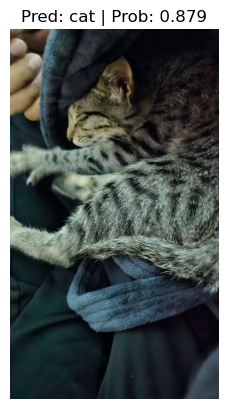

In [28]:
plot_and_pred_img(model=loaded_model,
                  image_path=custom_image_path,
                  class_names=class_names,
                  transform=test_transform)